FrozenLake Env: https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py
### ACTION:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

The episode ends when you reach the goal or fall in a hole.
You receive a reward of 1 if you reach the goal, and zero otherwise.

### Q-Neural Network Learning
tables are great, but they don’t really scale, do they? While it is easy to have a 16x4 table for a simple grid world, the number of possible states in any modern game or real-world environment is nearly infinitely larger. For most interesting problems, tables simply don’t work. We instead need some way to take a description of our state, and produce Q-values for actions without a table: that is where neural networks come in. By acting as a function approximator, we can take any number of possible states that can be represented as a vector and learn to map them to Q-values.

In the case of the FrozenLake example, we will be using a one-layer network which takes the state encoded in a one-hot vector (1x16), and produces a vector of 4 Q-values, one for each action. Such a simple network acts kind of like a glorified table, with the network weights serving as the old cells. The key difference is that we can easily expand the Tensorflow network with added layers, activation functions, and different input types, whereas all that is impossible with a regular table.

The method of updating is a little different as well. Instead of directly updating our table, with a network we will be using backpropagation and a loss function. Our loss function will be sum-of-squares loss, where the difference between the current predicted Q-values, and the “target” value is computed and the gradients passed through the network. In this case, our Q-target for the chosen action is the equivalent to the Q-value computed in equation 1 above.

Eq2. Loss = ∑(Q-target - Q)²


In [6]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
env = gym.make('FrozenLake-v0')

In [9]:
tf.reset_default_graph()
tf

<module 'tensorflow' from '/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/__init__.py'>

In [14]:
# 1. Initialize to establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1, 16], dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16, 4],0,0.01))
Qout = tf.matmul(inputs1, W)
predict = tf.argmax(Qout, 1)
print(inputs1)
print(W)
print(Qout)
print(predict)

Tensor("Placeholder_4:0", shape=(1, 16), dtype=float32)
<tf.Variable 'Variable_3:0' shape=(16, 4) dtype=float32_ref>
Tensor("MatMul_3:0", shape=(1, 4), dtype=float32)
Tensor("ArgMax_3:0", shape=(1,), dtype=int64)


In [15]:
# 2. Initialize to obtain the loss by taking the sum of squares difference between the target and prediciton Q Values.
nextQ = tf.placeholder(shape=[1,4], dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)
print(nextQ)
print(loss)
print(trainer)
print(updateModel)

Tensor("Placeholder_5:0", shape=(1, 4), dtype=float32)
Tensor("Sum:0", shape=(), dtype=float32)
name: "GradientDescent"
op: "NoOp"
input: "^GradientDescent/update_Variable_3/ApplyGradientDescent"



In [16]:
# 3. Training the Network

# set learning parameters
y = .99
e = 0.1
num_episodes = 2000

# 2.2. Create lists to contain total rewards and steps per episode
rList = []
jList = []

## Observation / Next State from Env
### observation (object): 
an environment-specific object representing your observation of the environment. For example, pixel data from a camera, joint angles and joint velocities of a robot, or the board state in a board game.

### reward (float): 
amount of reward achieved by the previous action. The scale varies between environments, but the goal is always to increase your total reward.

### done (boolean): 
whether it’s time to reset the environment again. Most (but not all) tasks are divided up into well-defined episodes, and done being True indicates the episode has terminated. (For example, perhaps the pole tipped too far, or you lost your last life.)

### info (dict): 
diagnostic information useful for debugging. It can sometimes be useful for learning (for example, it might contain the raw probabilities behind the environment’s last state change). However, official evaluations of your agent are not allowed to use this for learning.


In [20]:
# 3. Implementation of Algorithm
init = tf.initialize_all_variables()
# Iterates according to number of episodes
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(num_episodes):
        # Reset Environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        # Implement Q-Table learning Algorithm
        while j < 99:
            j+=1
            # Choose an ACTION by greedily (with e chance of random action) picking from Q-network
            a, allQ = sess.run([predict, Qout], feed_dict={inputs1:np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            # Add Action to env and get new state, reward, done, and info
            s1, r, d, _ = env.step(a[0]) # see obvservation above      
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout, feed_dict={inputs1:np.identity(16)[s1:s1+1]})       
            # Obtain maxQ' and set our target value for chosen action
            #Q[s,a] = Q[s,a] + lr*(r + y * np.max(Q[s1,:]) - Q[s,a]) # this is the code from QTable!
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0, a[0]] = r + y*maxQ1 # Bellman Equation
            
            #Train our network using target and predicted Q values
            _, W1 = sess.run([updateModel, W], feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
            
            rAll += r
            s = s1
            if d == True:
                break
        jList.append(j)
        rList.append(rAll)

In [23]:
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Percent of succesful episodes: 0.285%


## Some statistics on network performance
We can see that the network beings to consistly reach the goal around the 750 episode mark.

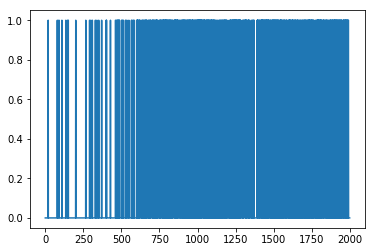

In [24]:
plt.plot(rList)

It also begins to progress through the environment for longer than chance aroudn the 750 mark as well

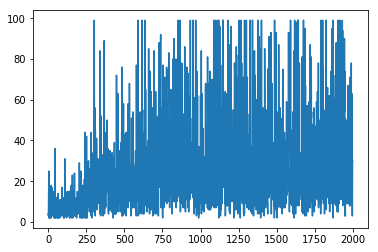

In [26]:
plt.plot(jList)